# Uptake of carbon

Plotting a global map of carbon uptake

In [2]:
%matplotlib inline

import xarray as xr
import intake
import numpy as np
from cmip6_preprocessing.preprocessing import read_data
import warnings

# util.py is in the local directory
# it contains code that is common across project notebooks
# or routines that are too extensive and might otherwise clutter
# the notebook design
import util 

/srv/conda/envs/notebook/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [3]:
def _compute_slope(y):
    """
    Private function to compute slopes at each grid cell using
    polyfit. 
    """
    x = np.arange(len(y))
    return np.polyfit(x, y, 1)[0] # return only the slope

def compute_slope(da):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
      da: xarray DataArray to compute slopes for
      
    Returns:
      xarray DataArray with slopes computed at each grid cell.
    """
    # apply_ufunc can apply a raw numpy function to a grid.
    # 
    # vectorize is only needed for functions that aren't already
    # vectorized. You don't need it for polyfit in theory, but it's
    # good to use when using things like np.cov.
    #
    # dask='parallelized' parallelizes this across dask chunks. It requires
    # an output_dtypes of the numpy array datatype coming out.
    #
    # input_core_dims should pass the dimension that is being *reduced* by this operation,
    # if one is being reduced.
    slopes = xr.apply_ufunc(_compute_slope,
                            da,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes

In [4]:
if util.is_ncar_host():
    col = intake.open_esm_datastore("../catalogs/glade-cmip6.json")
else:
    col = intake.open_esm_datastore("../catalogs/pangeo-cmip6.json")

In [5]:
cat = col.search(experiment_id=['historical'], table_id='Omon', variable_id=['dissic','thkcello'], grid_label='gn')

import pprint 
uni_dict = col.unique(['source_id', 'experiment_id', 'table_id'])
#pprint.pprint(uni_dict, compact=True)

In [6]:
models = set(uni_dict['source_id']['values']) # all the models

for experiment_id in ['historical']:
    query = dict(experiment_id=experiment_id, table_id='Omon', 
                 variable_id=['dissic','thkcello'], grid_label='gn')  
    cat = col.search(**query)
    models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

# for oxygen, ensure the CESM2 models are not included (oxygen was erroneously submitted to the archive)
# UKESM has an issue with the attributes
models = models - {'UKESM1-0-LL'}

models = list(models)
models

['GISS-E2-1-G',
 'GISS-E2-1-G-CC',
 'CNRM-ESM2-1',
 'BCC-ESM1',
 'CESM2',
 'CNRM-CM6-1',
 'MIROC-ES2L',
 'CanESM5',
 'IPSL-CM6A-LR',
 'HadGEM3-GC31-LL',
 'BCC-CSM2-MR']

In [7]:
# read all data with volume and oxygen
with warnings.catch_warnings(): # these lines just make sure that the warnings dont clutter your notebook
    warnings.simplefilter("ignore")
    data_dict_thk = read_data(col,
                    experiment_id=['historical'],
                    grid_label='gn',
                    variable_id=['thkcello','dissic'],
                    table_id = ['Omon','Ofx'],
                    source_id = models,
                    #member_id = 'r1i1p1f1', # so that this runs faster for testing
                    required_variable_id = ['thkcello','dissic']
                    )

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 7 group(s)
CanESM5
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
CNRM-ESM2-1
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid
IPSL-CM6A-LR
NON-REFERENCE MODE. This should just be used for a bunch of variables on the same grid


In [8]:
data_dict_thk['IPSL-CM6A-LR'].rename({'olevel':'lev'})

<xarray.Dataset>
Dimensions:        (axis_nbounds: 2, lev: 75, member_id: 1, nvertex: 4, time: 1980, x: 362, x_right: 362, y: 332, y_right: 332)
Coordinates:
  * time           (time) datetime64[ns] 1850-01-16T12:00:00 ... 2014-12-16T12:00:00
  * lev            (lev) float32 0.50576 1.5558553 ... 5698.0605 5902.0576
  * member_id      (member_id) <U9 'r10i1p1f1'
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 354 355 356 357 358 359 360 361
  * x_right        (x_right) float64 0.5 1.5 2.5 3.5 ... 358.5 359.5 360.5 361.5
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330 331
  * y_right        (y_right) float64 0.5 1.5 2.5 3.5 ... 328.5 329.5 330.5 331.5
    dxe            (y, x_right) float64 1.127e+04 1.127e+04 ... 777.7 777.7
    dyn            (y_right, x) float64 1.136e+04 1.136e+04 ... 1.49e+07
    dxt            (y, x) float64 1.127e+04 1.127e+04 ... 1.71e+03 777.7
    dxne           (y_right, x_right) float64 1.136e+04 1.136e+04 ... 6.022e+03
    dxn  

### Loading data

`intake-esm` enables loading data directly into an [xarray.Dataset](http://xarray.pydata.org/en/stable/api.html#dataset).

Note that data on the cloud are in 
[zarr](https://zarr.readthedocs.io/en/stable/) format and data on 
[glade](https://www2.cisl.ucar.edu/resources/storage-and-file-systems/glade-file-spaces) are stored as 
[netCDF](https://www.unidata.ucar.edu/software/netcdf/) files. This is opaque to the user.

`intake-esm` has rules for aggegating datasets; these rules are defined in the collection-specification file.

In [38]:
cat = col.search(experiment_id=['historical'], table_id='Omon', 
                 variable_id=['dissic','thkcello'], grid_label='gn', source_id=models)

In [39]:
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {'time' : 20}, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 11 group(s)


`dset_dict` is a dictionary of `xarray.Dataset`'s; its keys are constructed to refer to compatible groups.

In [40]:
dset_dict.keys()

dict_keys(['CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn', 'CMIP.BCC.BCC-ESM1.historical.Omon.gn', 'CMIP.CCCma.CanESM5.historical.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-CM6-1.historical.Omon.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Omon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Omon.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Omon.gn', 'CMIP.MOHC.HadGEM3-GC31-LL.historical.Omon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Omon.gn', 'CMIP.NCAR.CESM2.historical.Omon.gn'])

We can access a particular dataset as follows.

In [42]:
dsC = dset_dict['CMIP.BCC.BCC-CSM2-MR.historical.Omon.gn']

In [43]:
dsC

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 232, lev: 40, lon: 360, member_id: 1, time: 1980)
Coordinates:
  * lev        (lev) float64 5.0 15.0 25.0 ... 4.289e+03 4.807e+03 5.334e+03
  * lon        (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) float64 15.5 45.0 74.5 ... 6.015e+04 6.018e+04 6.021e+04
  * lat        (lat) float64 -81.5 -80.5 -79.5 -78.5 ... 86.5 87.5 88.5 89.5
  * member_id  (member_id) <U8 'r1i1p1f1'
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) int64 dask.array<chunksize=(1980, 2), meta=np.ndarray>
    lev_bnds   (lev, bnds) float64 dask.array<chunksize=(40, 2), meta=np.ndarray>
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(360, 2), meta=np.ndarray>
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(232, 2), meta=np.ndarray>
    latitude   (lat, lon) float32 dask.array<chunksize=(232, 360), meta=np.ndarray>
    longitude  (lat, lon) float32 dask.array<chunksize=(232, 360), met

In [18]:
# Iterate over models

In [18]:
from dask.distributed import Client

client = Client("tcp://10.32.12.63:46685")
client

<Client: 'tcp://10.32.12.63:46685' processes=30 threads=60, memory=345.00 GB>

In [19]:
data_dict_thk.keys()

dict_keys(['CanESM5', 'CNRM-ESM2-1', 'IPSL-CM6A-LR'])

In [28]:
for model_key in data_dict_thk.keys():
    dsC = data_dict_thk[model_key]
    ds = dsC['dissic'].isel(lev = 0,member_id = 0).chunk({'time': 20*12, 'x': 110, 'y': 110})
    dz = dsC['thkcello'].isel(member_id=0)
    DICstore_slope = (ds.isel(time=-np.arange(10*12)).mean('time')*dz-ds.isel(time=np.arange(10*12)).mean('time')*dz).sum('lev')
    #slope = compute_slope(ds)
    #slope = slope.compute()
    DICstore_slope.plot()

KilledWorker: ("('zarr-51083cf3fafe90e779099311eca493a6', 141, 0, 0, 0)", <Worker 'tcp://10.32.4.31:45933', memory: 0, processing: 5>)

In [33]:
DICstore_slope.values

KilledWorker: ("('zarr-51083cf3fafe90e779099311eca493a6', 164, 0, 0, 0)", <Worker 'tcp://10.32.24.19:42421', memory: 0, processing: 4>)

In [17]:
cat_fx = col.search(source_id=models, table_id='Ofx', grid_label='gn')
cat_fx.df
cat_fx.df.drop_duplicates(subset=['source_id', 'variable_id'], inplace=True)

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
cat_fx.df

activity_id institution_id       source_id experiment_id  member_id  \
1435         CMIP          CCCma         CanESM5    historical  r10i1p1f1   
1436         CMIP          CCCma         CanESM5    historical  r10i1p1f1   
1437         CMIP          CCCma         CanESM5    historical  r10i1p1f1   
1438         CMIP          CCCma         CanESM5    historical  r10i1p1f1   
5309         CMIP   CNRM-CERFACS     CNRM-ESM2-1    historical   r1i1p1f2   
5387         CMIP   CNRM-CERFACS     CNRM-ESM2-1    historical   r2i1p1f2   
5388         CMIP   CNRM-CERFACS     CNRM-ESM2-1    historical   r2i1p1f2   
6516         CMIP           IPSL    IPSL-CM6A-LR    historical  r10i1p1f1   
6517         CMIP           IPSL    IPSL-CM6A-LR    historical  r10i1p1f1   
9079         CMIP           IPSL    IPSL-CM6A-LR     piControl   r1i1p1f1   
9080         CMIP           IPSL    IPSL-CM6A-LR     piControl   r1i1p1f1   
9233         CMIP          MIROC      MIROC-ES2L    historical   r1i1p1f2   
9234         CMIP          MIROC      MIROC-ES2L    historical   r1i1p1f2   
9235         CMIP          MIROC      MIROC-ES2L    historical   r1i1p1f2   
10959        CMIP           MOHC     UKESM1-0-LL     piControl   r1i1p1f2   
10960        CMIP           MOHC     UKESM1-0-LL     piControl   r1i1p1f2   
10961        CMIP           MOHC     UKESM1-0-LL     piControl   r1i1p1f2   
11522        CMIP      NASA-GISS  GISS-E2-1-G-CC     piControl   r1i1p1f1   
11523        CMIP      NASA-GISS  GISS-E2-1-G-CC     piControl   r1i1p1f1   
11524        CMIP      NASA-GISS  GISS-E2-1-G-CC     piControl   r1i1p1f1   
12482        CMIP      NASA-GISS     GISS-E2-1-G     piControl   r1i1p1f1   
12483        CMIP      NASA-GISS     GISS-E2-1-G     piControl   r1i1p1f1   
12484        CMIP      NASA-GISS     GISS-E2-1-G     piControl   r1i1p1f1   
14191        CMIP           NCAR           CESM2    historical  r10i1p1f1   
14193        CMIP           NCAR           CESM2    historical  r10i1p1f1   
14195        CMIP           NCAR           CESM2    historical  r10i1p1f1   
14196        CMIP           NCAR           CESM2    historical  r10i1p1f1   

      table_id variable_id grid_label  \
1435       Ofx   areacello         gn   
1436       Ofx      deptho         gn   
1437       Ofx       sftof         gn   
1438       Ofx    thkcello         gn   
5309       Ofx   areacello         gn   
5387       Ofx       basin         gn   
5388       Ofx      deptho         gn   
6516       Ofx   areacello         gn   
6517       Ofx       basin         gn   
9079       Ofx       sftof         gn   
9080       Ofx    thkcello         gn   
9233       Ofx   areacello         gn   
9234       Ofx      deptho         gn   
9235       Ofx       sftof         gn   
10959      Ofx   areacello         gn   
10960      Ofx       basin         gn   
10961      Ofx       sftof         gn   
11522      Ofx   areacello         gn   
11523      Ofx       basin         gn   
11524      Ofx       sftof         gn   
12482      Ofx   areacello         gn   
12483      Ofx       basin         gn   
12484      Ofx       sftof         gn   
14191      Ofx   areacello         gn   
14193      Ofx      deptho         gn   
14195      Ofx       sftof         gn   
14196      Ofx    volcello         gn   

                                                  zstore  dcpp_init_year  
1435   gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...             NaN  
1436   gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...             NaN  
1437   gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...             NaN  
1438   gs://cmip6/CMIP/CCCma/CanESM5/historical/r10i1...             NaN  
5309   gs://cmip6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/histo...             NaN  
5387   gs://cmip6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/histo...             NaN  
5388   gs://cmip6/CMIP/CNRM-CERFACS/CNRM-ESM2-1/histo...             NaN  
6516   gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...             NaN  
6517   gs://cmip6/CMIP/IP

In [19]:
dset_dict_fx = cat_fx.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False}, 
                                cdf_kwargs={'chunks': {}, 'decode_times': False})

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 9 group(s)


In [20]:
dset_dict_fx.keys()

dict_keys(['CMIP.CCCma.CanESM5.historical.Ofx.gn', 'CMIP.CNRM-CERFACS.CNRM-ESM2-1.historical.Ofx.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Ofx.gn', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Ofx.gn', 'CMIP.MIROC.MIROC-ES2L.historical.Ofx.gn', 'CMIP.MOHC.UKESM1-0-LL.piControl.Ofx.gn', 'CMIP.NASA-GISS.GISS-E2-1-G.piControl.Ofx.gn', 'CMIP.NASA-GISS.GISS-E2-1-G-CC.piControl.Ofx.gn', 'CMIP.NCAR.CESM2.historical.Ofx.gn'])

In [19]:
ds_fx = dset_dict['CMIP.CCCma.CanESM5.historical.Ofx.gn']

In [20]:
import numpy as np
import matplotlib.pyplot as plt

DICstore0 = (dsC.dissic.isel(time=(164-np.arange(10))).mean('time')*ds_fx.thkcello.isel(member_id=0)-dsC.dissic.isel(time=np.arange(10)).mean('time')*ds_fx.thkcello.isel(member_id=0)).sum('lev')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


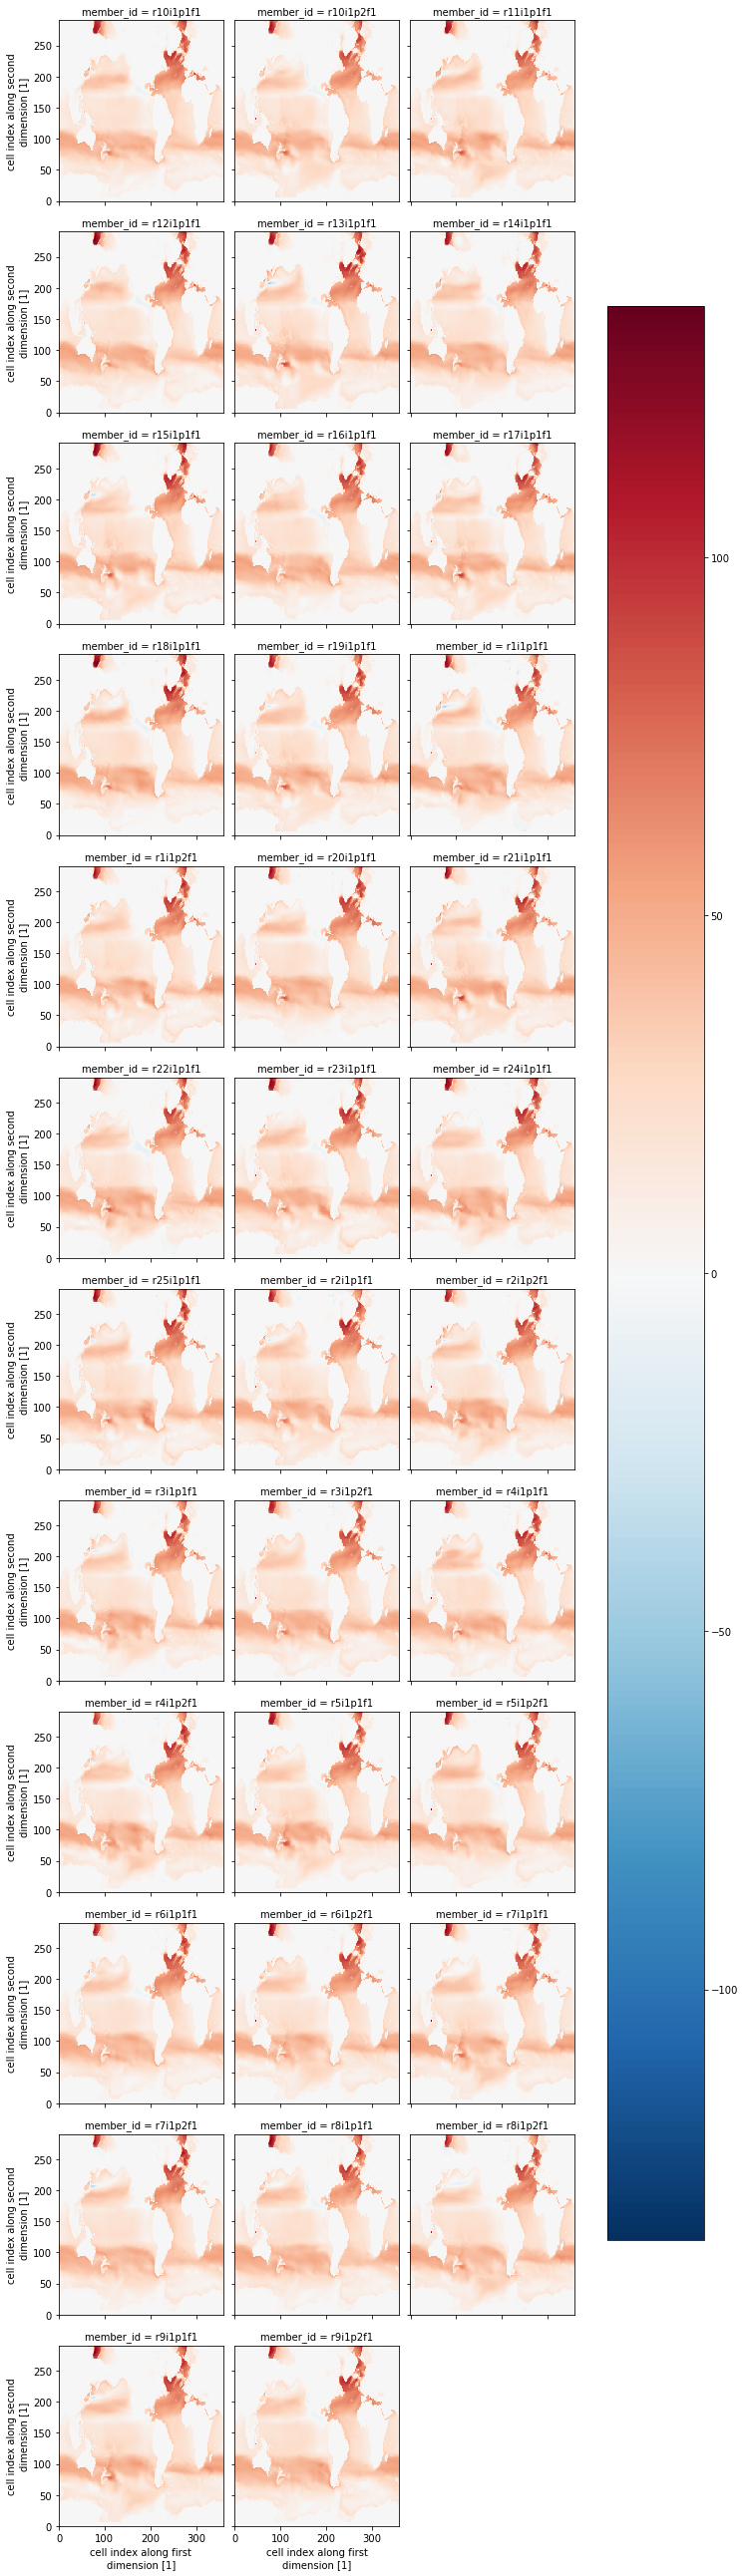

In [21]:
DICstore0.plot(col='member_id', col_wrap=3)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


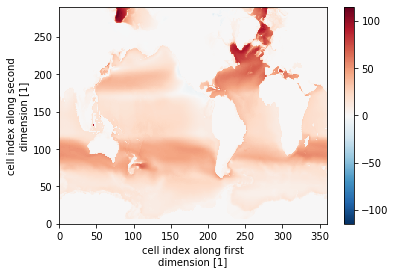

In [23]:
DICstore0.mean('member_id').plot()

In [24]:
DICsurf0 = dsC.dissic.isel(lev = 0,time=(164-np.arange(10))).mean('time')-dsC.dissic.isel(lev = 0,time=np.arange(10)).mean('time')

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


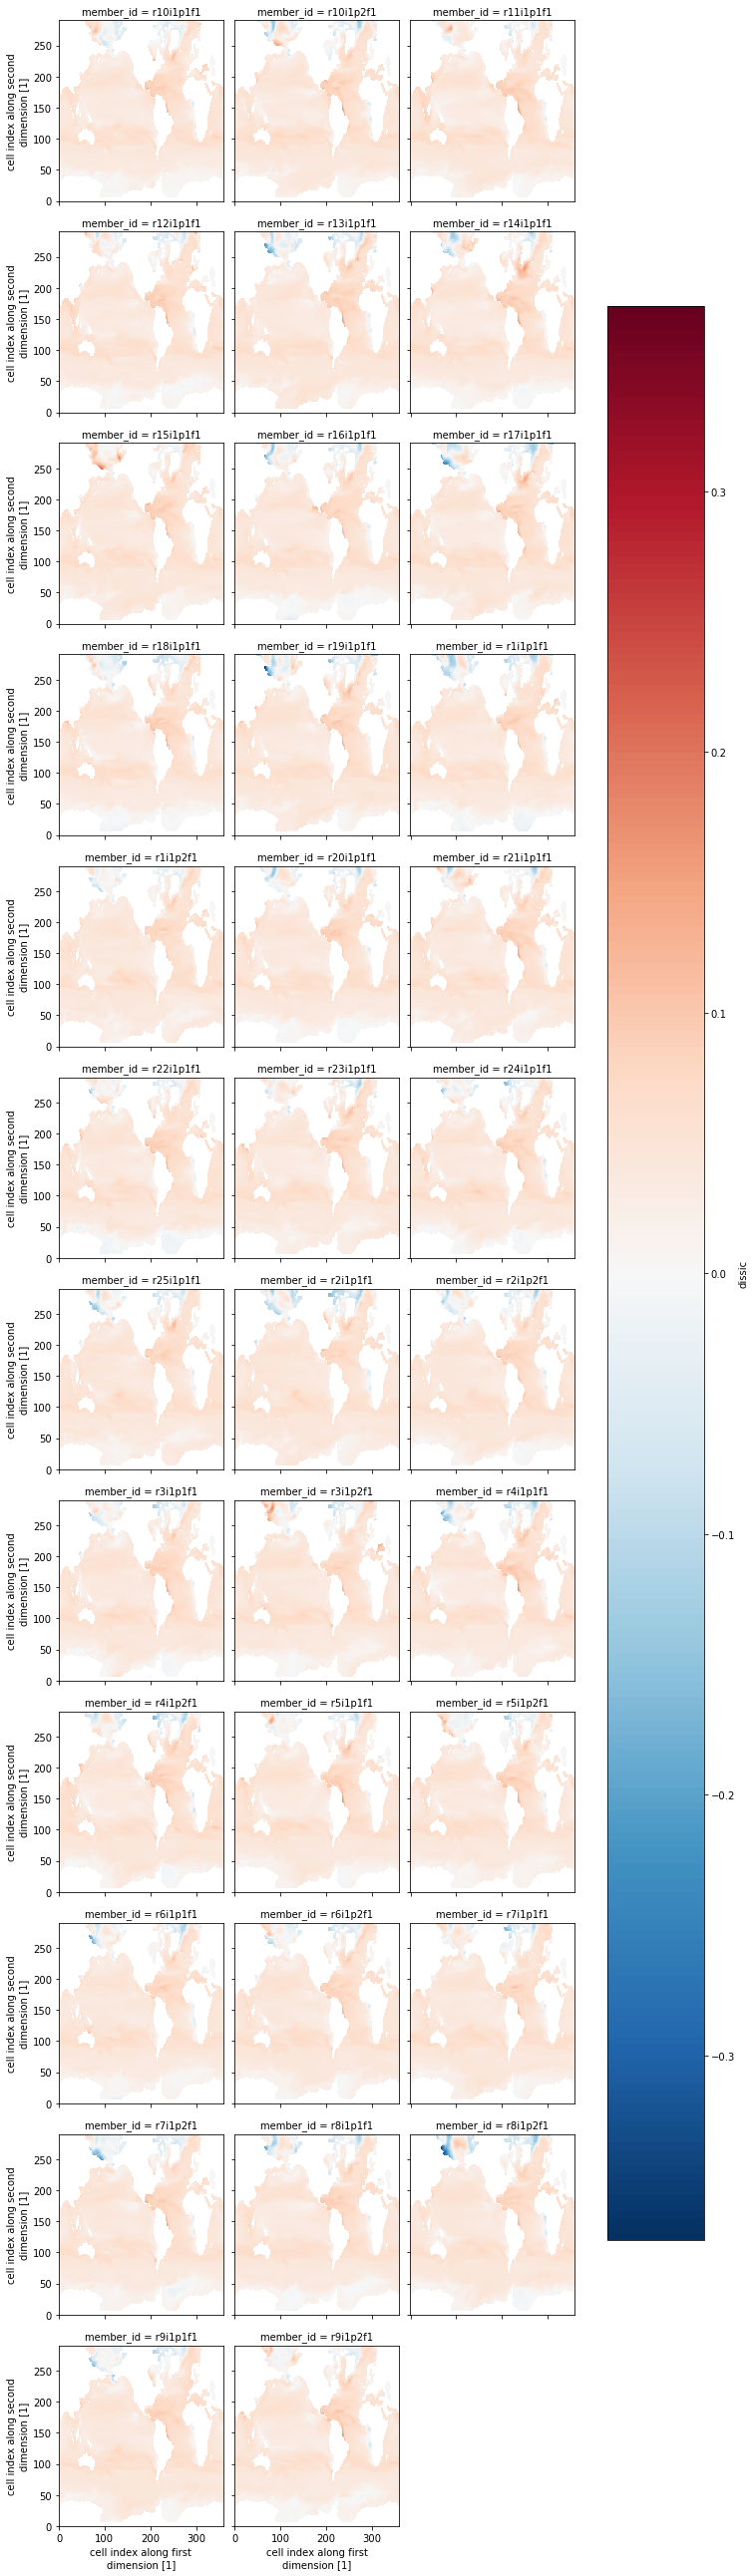

In [25]:
DICsurf0.plot(col='member_id', col_wrap=3)

/srv/conda/envs/notebook/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


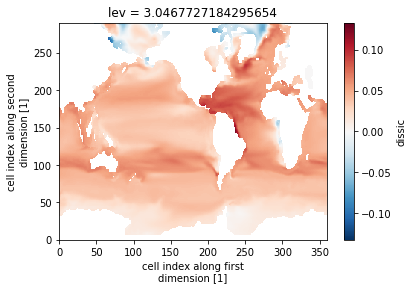

In [26]:
DICsurf0.mean('member_id').plot()

In [27]:
ds = dsC['dissic'].isel(lev = 0).chunk({'time': -1, 'member_id': 1, 'i': -1, 'j': 110})
ds.data

dask.array<rechunk-merge, shape=(35, 165, 291, 360), dtype=float32, chunksize=(1, 165, 110, 360), chunktype=numpy.ndarray>

In [29]:
from dask.distributed import Client

client = Client("tcp://10.32.12.63:34981")
client

<Client: 'tcp://10.32.12.63:34981' processes=0 threads=0, memory=0 B>

In [30]:
slope = compute_slope(ds)

In [31]:
slope = slope.compute()

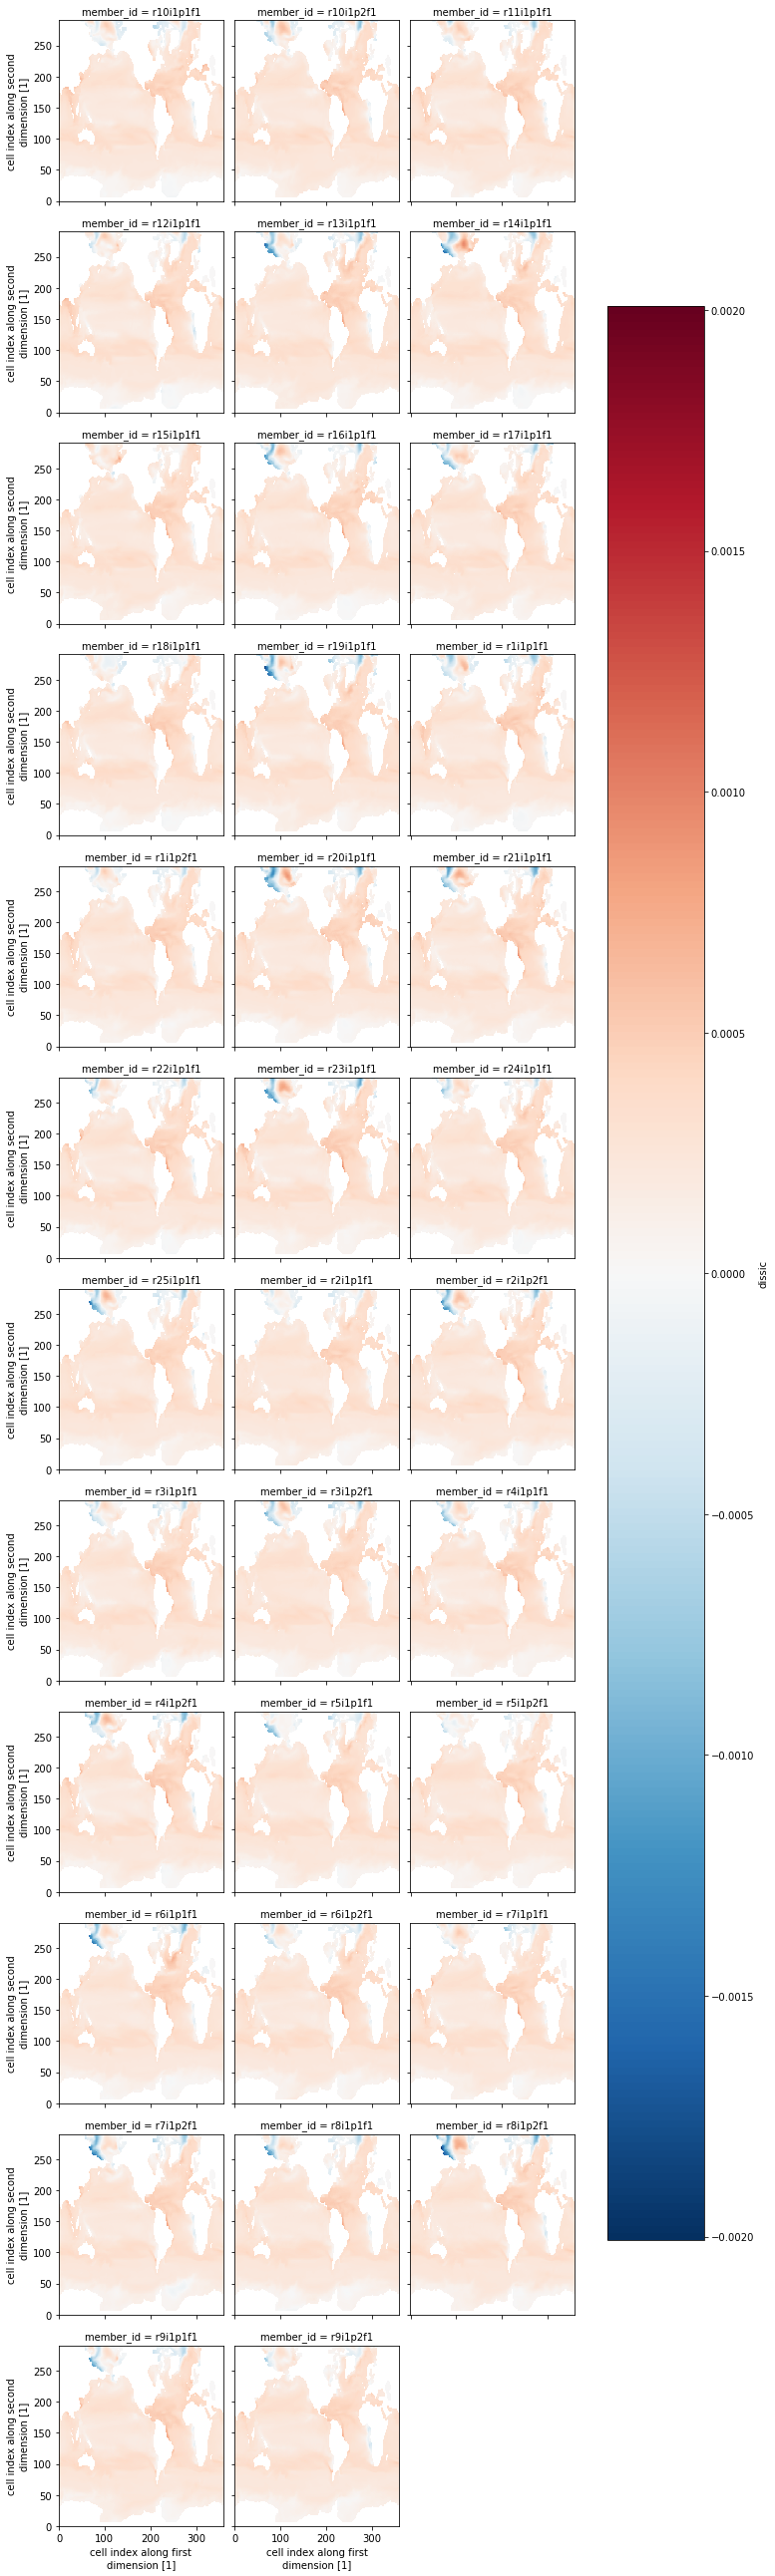

In [32]:
slope.plot(col='member_id', col_wrap=3)

/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


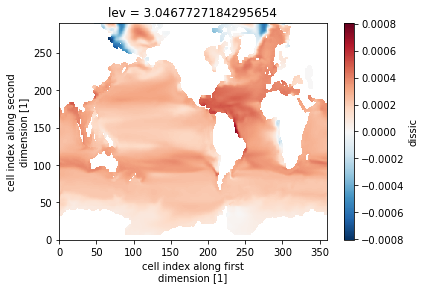

In [33]:
slope.mean('member_id').plot()

In [34]:
DICstore = (dsC.dissic*ds_fx.thkcello.isel(member_id=0)).sum('lev').chunk({'time': -1, 'member_id': 1, 'i': -1, 'j': 110})

In [35]:
DICstore.data

dask.array<rechunk-merge, shape=(35, 165, 291, 360), dtype=float32, chunksize=(1, 165, 110, 360), chunktype=numpy.ndarray>

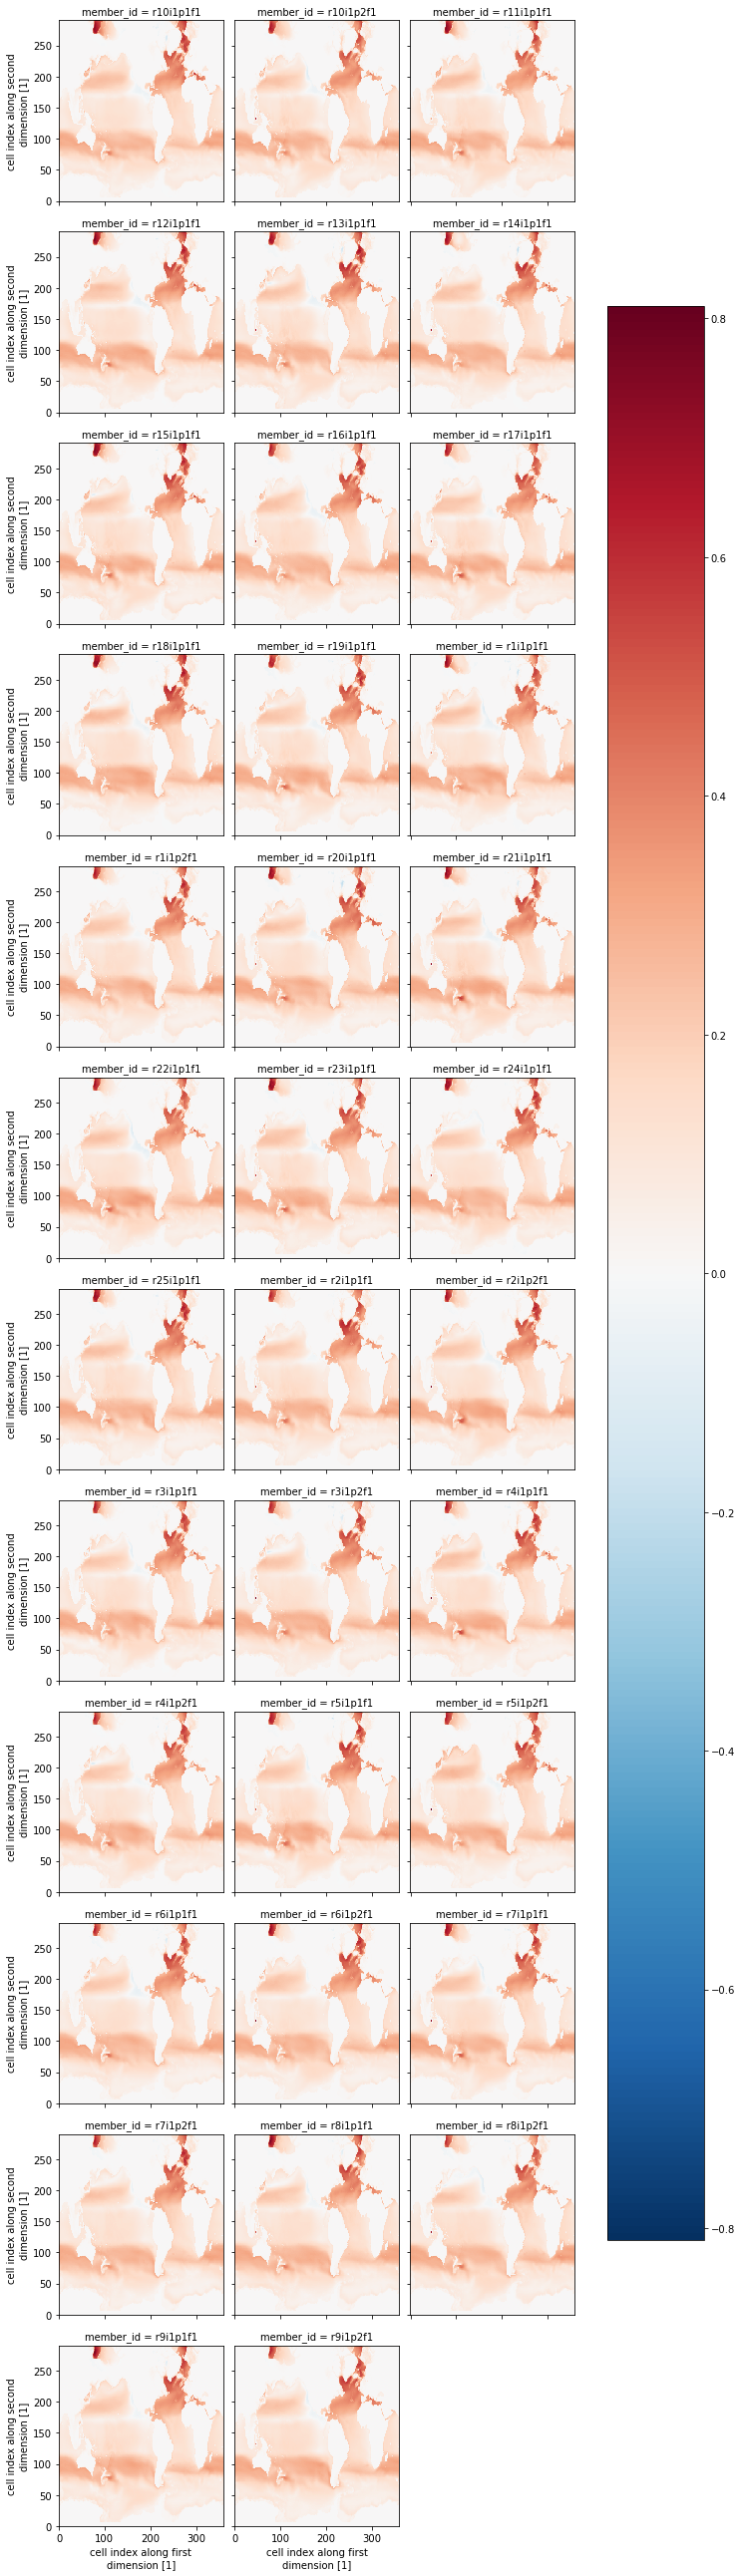

In [36]:
slope = compute_slope(DICstore)
slope = slope.compute()
slope.plot(col='member_id', col_wrap=3)

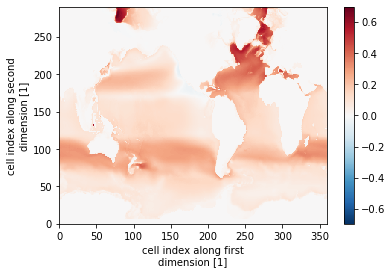

In [42]:
fig = slope.mean('member_id').plot()